
*2. Improve the architecture*

Experiment with different numbers of layers, size of layers, number of filters, size of filters. You are required to make those adjustment to get the highest accuracy. Watch out for overfitting -- we want the highest testing accuracy! Please provide a PDF file of the result, the best test accuracy and the architecture (different numbers of layers, size of layers, number of filters, size of filters)

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from datetime import datetime

import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

from PIL import Image


In [7]:
github_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

fmnist_dataset = FashionMNIST(root = 'data/', download=True, train = True, transform = transforms.ToTensor())

print(fmnist_dataset)

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.31MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 121kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.25MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.94MB/s]

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [9]:
train_data, validation_data = random_split(fmnist_dataset, [50000, 10000])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True) # true, bo tasujemy dla lepszego uczenia się
val_loader = DataLoader(validation_data, batch_size, shuffle = False) # fal


test_dataset = FashionMNIST(root = 'data/', train = False, transform = transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = False)


length of Train Datasets:  50000
length of Validation Datasets:  10000


In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

class OptimizedCNN(nn.Module):
    def __init__(self, conv_channels=[16, 32], kernel_size=3, fc_size=128):
        super(OptimizedCNN, self).__init__()
        self.convs = nn.ModuleList()

        in_channels = 1
        for out_channels in conv_channels:
            self.convs.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                )
            )
            in_channels = out_channels

        # size after convolutions
        self.flatten_size = out_channels * (28 // (2 ** len(conv_channels))) ** 2

        self.fc = nn.Linear(self.flatten_size, fc_size)
        self.out = nn.Linear(fc_size, 10)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        output = self.out(x)
        return output, x

cnn = OptimizedCNN()
print(cnn)

OptimizedCNN(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc): Linear(in_features=1568, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
from torch.autograd import Variable

def train(num_epochs, cnn, loaders):
    cnn.train()
    optimizer = optim.Adam(cnn.parameters(), lr=0.01)
    loss_func = nn.CrossEntropyLoss()

    all_accuracies = []

    total_step = len(loaders)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(loaders):
            b_x = Variable(images)  # batch x
            b_y = Variable(labels)  # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i+1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

        avg_loss = epoch_loss / total_step
        accuracy = 100 * correct / total

        all_accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return all_accuracies

In [12]:
architectures = [
    {'conv_channels': [8, 16], 'kernel_size': 3, 'fc_size': 64},
    {'conv_channels': [16, 32], 'kernel_size': 3, 'fc_size': 128},
    {'conv_channels': [32, 64], 'kernel_size': 5, 'fc_size': 128},
    {'conv_channels': [32, 128], 'kernel_size': 5, 'fc_size': 256},
    {'conv_channels': [8, 16, 32], 'kernel_size': 3, 'fc_size': 128},
    {'conv_channels': [16, 32, 64], 'kernel_size': 3, 'fc_size': 256},
    {'conv_channels': [16, 32, 128], 'kernel_size': 5, 'fc_size': 256},
    {'conv_channels': [8, 16, 32, 64], 'kernel_size': 3, 'fc_size': 256},
    {'conv_channels': [16, 32, 64, 128], 'kernel_size': 3, 'fc_size': 256},
    {'conv_channels': [16, 32, 64, 128], 'kernel_size': 5, 'fc_size': 256},
]

results = []

for config in architectures:
    print(f"Testing architecture: {config}")

    # Tworzenie modelu
    cnn = OptimizedCNN(conv_channels=config['conv_channels'],
                       kernel_size=config['kernel_size'],
                       fc_size=config['fc_size'])

    # counting initial accuracies and lossess
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        epoch_loss = 0.0
        for images, labels in train_loader:
            test_output, _ = cnn(images)
            loss = nn.CrossEntropyLoss()(test_output, labels)
            epoch_loss += loss.item()

            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)

        initial_accuracy = correct / total
        initial_loss = epoch_loss / total  # avg starting loss

    print(f"Initial accuracy: {initial_accuracy:.2f}")

    # saving the first accuracy
    accuracies = [initial_accuracy]

    # training
    train_accuracies = train(num_epochs=5, cnn=cnn, loaders=train_loader)

    accuracies.extend(train_accuracies)

    # accuracy after training
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            test_output, _ = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)
        final_accuracy = correct / total

    print(f"Final accuracy: {final_accuracy:.2f}")

    results.append({
        'config': config,
        'initial_accuracy': initial_accuracy,
        'final_accuracy': final_accuracy,
        'accuracies': accuracies
    })

Testing architecture: {'conv_channels': [8, 16], 'kernel_size': 3, 'fc_size': 64}
Initial accuracy: 0.12
Epoch [1/5], Step [100/391], Loss: 0.6208
Epoch [1/5], Step [200/391], Loss: 0.3589
Epoch [1/5], Step [300/391], Loss: 0.3651
Epoch [1/5] - Loss: 0.4961, Accuracy: 81.95%
Epoch [2/5], Step [100/391], Loss: 0.2894
Epoch [2/5], Step [200/391], Loss: 0.2846
Epoch [2/5], Step [300/391], Loss: 0.2823
Epoch [2/5] - Loss: 0.3459, Accuracy: 87.61%
Epoch [3/5], Step [100/391], Loss: 0.2716
Epoch [3/5], Step [200/391], Loss: 0.3100
Epoch [3/5], Step [300/391], Loss: 0.3763
Epoch [3/5] - Loss: 0.3223, Accuracy: 88.34%
Epoch [4/5], Step [100/391], Loss: 0.1752
Epoch [4/5], Step [200/391], Loss: 0.2606
Epoch [4/5], Step [300/391], Loss: 0.2913
Epoch [4/5] - Loss: 0.3045, Accuracy: 88.95%
Epoch [5/5], Step [100/391], Loss: 0.4153
Epoch [5/5], Step [200/391], Loss: 0.2127
Epoch [5/5], Step [300/391], Loss: 0.2228
Epoch [5/5] - Loss: 0.2974, Accuracy: 89.13%
Final accuracy: 0.90
Testing architectur

[{'config': {'conv_channels': [8, 16], 'kernel_size': 3, 'fc_size': 64}, 'initial_accuracy': 0.12446, 'final_accuracy': 0.89696, 'accuracies': [0.12446, 81.952, 87.606, 88.338, 88.946, 89.128]}, {'config': {'conv_channels': [16, 32], 'kernel_size': 3, 'fc_size': 128}, 'initial_accuracy': 0.11168, 'final_accuracy': 0.88472, 'accuracies': [0.11168, 81.032, 87.016, 87.952, 87.984, 88.538]}, {'config': {'conv_channels': [32, 64], 'kernel_size': 5, 'fc_size': 128}, 'initial_accuracy': 0.06554, 'final_accuracy': 0.8955, 'accuracies': [0.06554, 81.182, 86.75, 87.638, 88.094, 88.458]}, {'config': {'conv_channels': [32, 128], 'kernel_size': 5, 'fc_size': 256}, 'initial_accuracy': 0.12448, 'final_accuracy': 0.88238, 'accuracies': [0.12448, 75.468, 86.364, 87.356, 87.594, 87.884]}, {'config': {'conv_channels': [8, 16, 32], 'kernel_size': 3, 'fc_size': 128}, 'initial_accuracy': 0.09418, 'final_accuracy': 0.88838, 'accuracies': [0.09418, 78.944, 86.032, 87.202, 87.76, 88.238]}, {'config': {'conv_ch

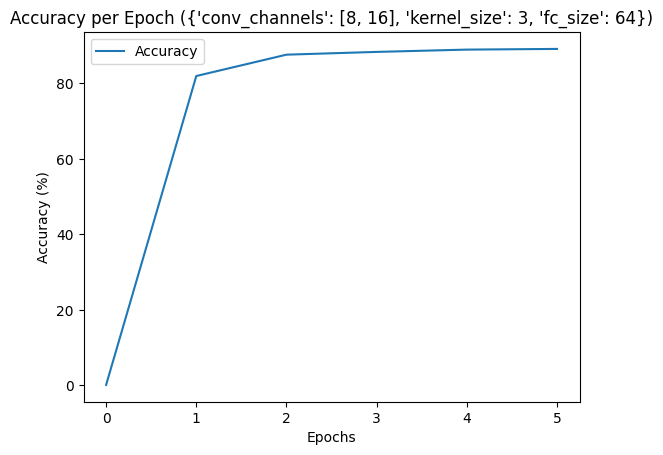

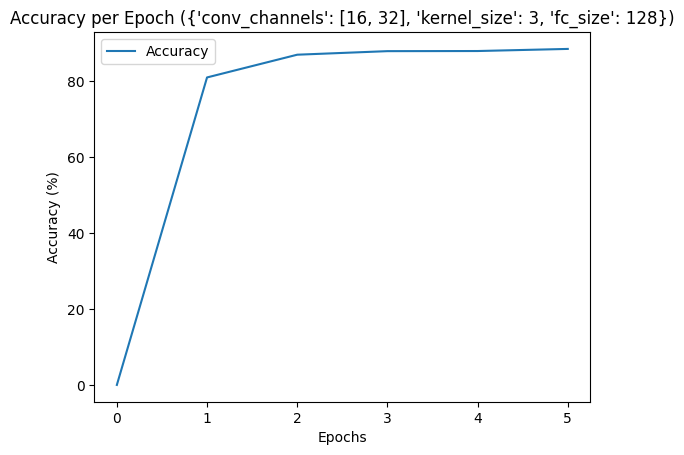

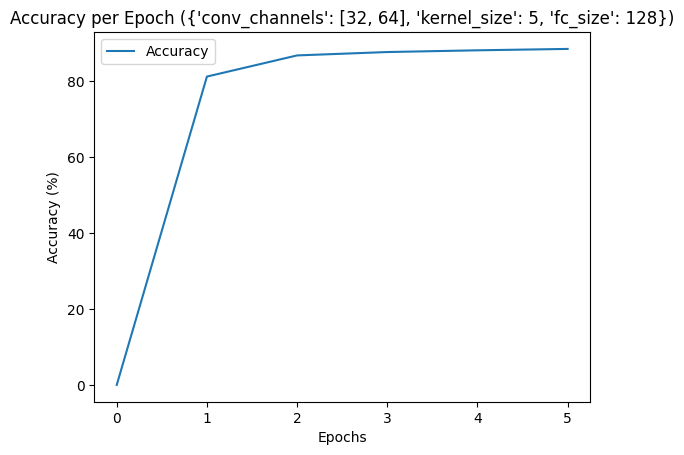

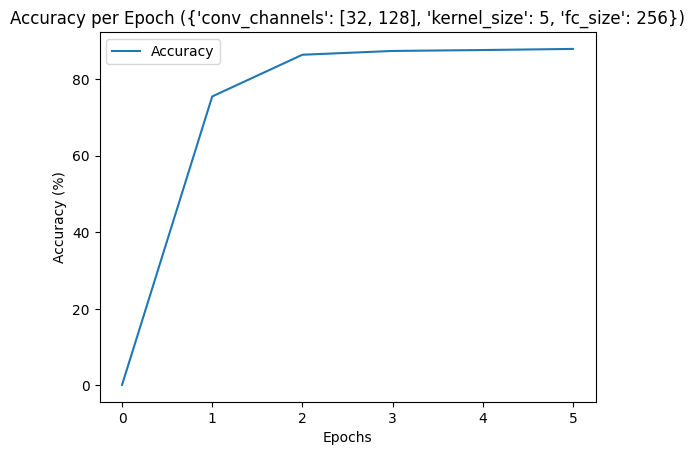

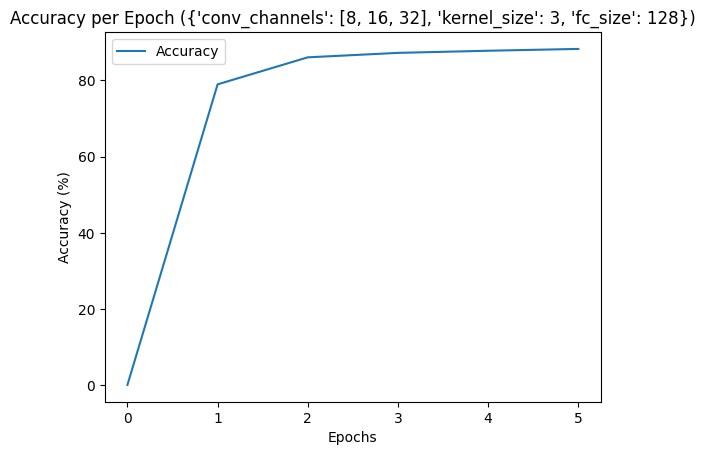

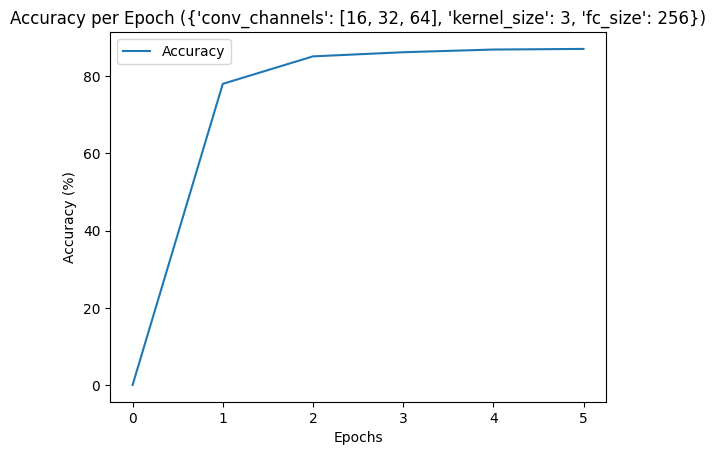

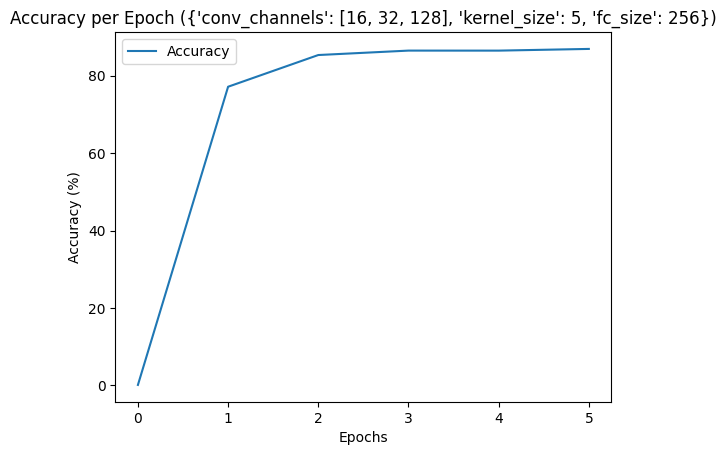

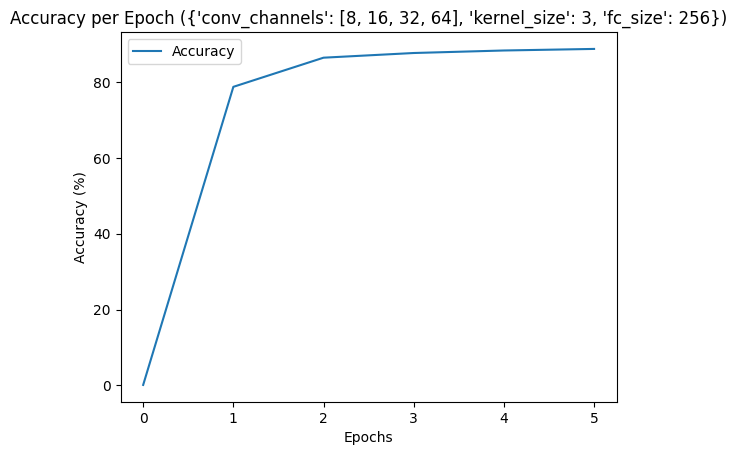

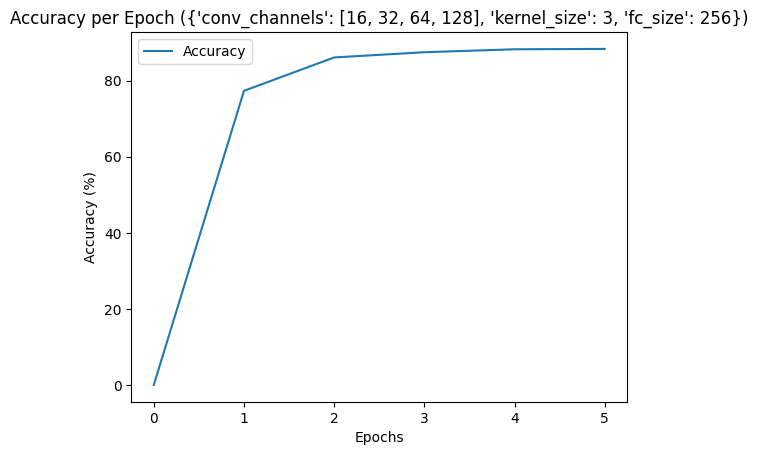

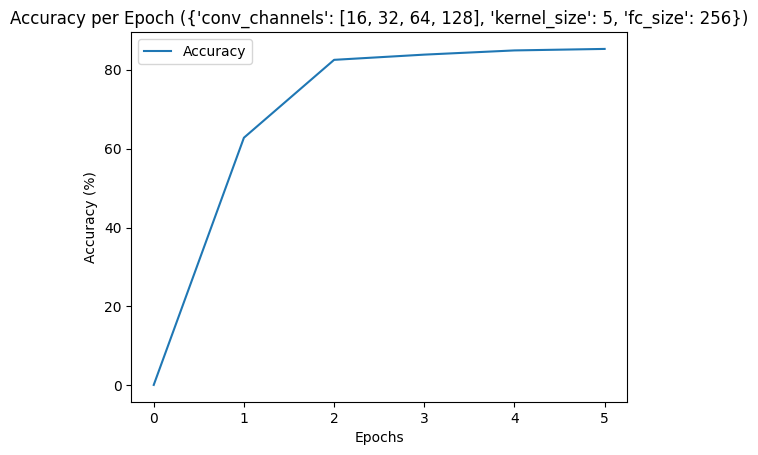

In [13]:
import matplotlib.pyplot as plt

print(results)

for result in results:
    plt.plot(result['accuracies'], label='Accuracy')
    plt.title(f"Accuracy per Epoch ({result['config']})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

In [16]:
best_model = max(results, key=lambda x: x['final_accuracy'])

print("Best architecture:")
print(f"Config: {best_model['config']}")
print(f"Initial accuracy: {best_model['initial_accuracy']:.4f}")
print(f"Final accuracy: {best_model['final_accuracy']:.4f}")




Best architecture:
Config: {'conv_channels': [8, 16], 'kernel_size': 3, 'fc_size': 64}
Initial accuracy: 0.1245
Final accuracy: 0.8970
